### sampling  
  
image sampling by stamp and data project folder  
projects are measurements of  
>Nitrit NO2, Phosphat PO4, Ammonium NH4  
  
>for further clustering of the image data color space and metric is given  
clustering is done by a derived kmeans method by the adapted module **ZMeans**  

In [2]:
import os
import numpy as np
import datetime, socket

import matplotlib.pyplot as plt

# a specific KMeans module
from _ZMeans import ZMeansUtils,ZMeans

# select project data
fdate = "2023-06-14"
fprojects = ["Nitrit NO2","Phosphat PO4","Ammonium NH4"]
fproject = fprojects[0]

fpath = os.path.join(os.getcwd(),"data",fdate,fproject)

if not os.path.exists(os.path.join(fpath,"result")): os.mkdir(os.path.join(fpath,"result"))

flabels = [flabel for flabel in os.listdir(fpath) if os.path.isdir(os.path.join(fpath,flabel)) and flabel not in ["result"]]
flabels = sorted(flabels,key=float)

ffolders = [os.path.join(fpath,flabel) for flabel in flabels]

findex = 0
fnames = [os.path.join(ffolder,os.listdir(ffolder)[findex]) for ffolder in ffolders]

metric = "euclidean"
space = "lab"

print(f"author  {socket.gethostname():>28}")
print(f"version {str(datetime.datetime.now()):>28}")


author                           NOB
version   2023-08-20 04:06:46.758131


### cluster

every sample image from a project, reagent and concentration folder will be clustered in the given color space  
image file names are still given in a variable of <code>fnames</code> (see above)  
  
results will be stored in <code>items</code>  
  
steps  
>load image in color space  
reshape image to a color space vector  
cluster with <code>k=3</code> and given metric 
retrieve centers and labels and scores of the partitions  
  
the count k of clusters, color space and metric where choosen experimental  

In [3]:
items = []
for fname in fnames:
  
  lab,bgr,rgb = ZMeansUtils.image_(fname)
  
  image = lab if space=="lab" else rgb
  centers,labels = ZMeansUtils.cluster_(image.reshape(-1,3),k=3,metric=metric)
  score = ZMeans.score_partition(labels)

  items.append(
    dict(
      fname=fname,
      lab=lab,bgr=bgr,rgb=rgb,image=image,
      centers=centers,labels=labels,
      score=score
    )
  )

### build
  
build and plot then partitions given by the clustering  
  
steps for every item in <code>items</code>:  
  
- load item data
- reshape every sample in cluster space to clustered image views
- mask the information relevant area  to crop (pixel) data to analyze
- map a sample to a colormap that counts the data equally for every project
- zoom the sample image to the relevant mask area
- extract partitions by k clusters to black and a light-dark vision
  
an information elevant area is non-black pixels that are connected and   
content of a light-dark vision color mapping is important to compare different projects in the same color space  
  
partitions are sorted from left to right by black, dark, light  
  
dark and light are information relevant and depends on the spot properties  
  
clustered image results a illustrated below  
  
the dataset illustration shows results for the first image of every concentration folder  
the NO2 sample holds concentrations of 0.04 to 0.151  

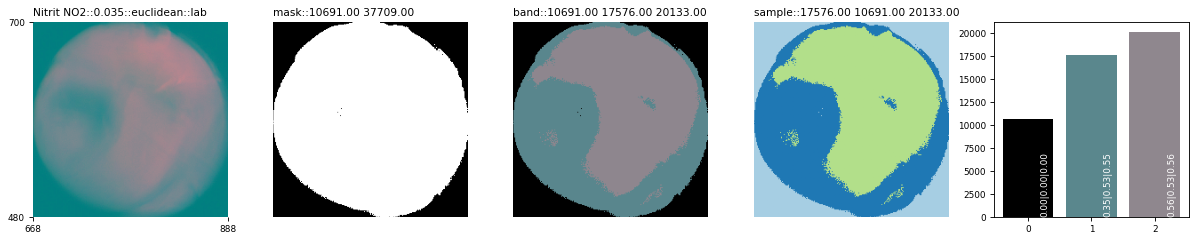

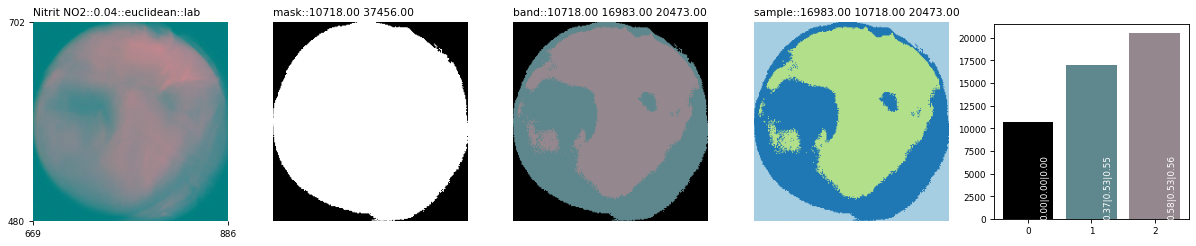

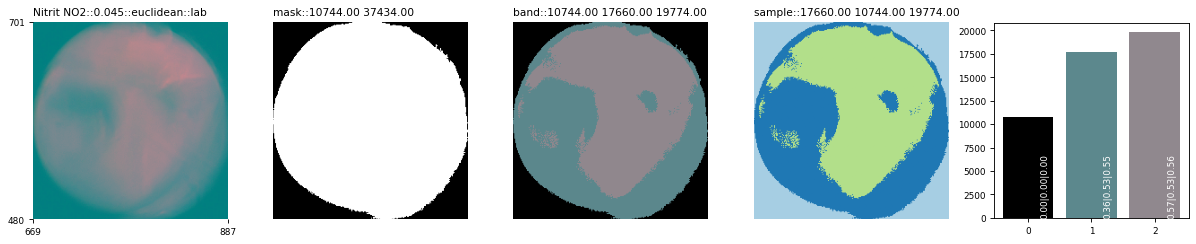

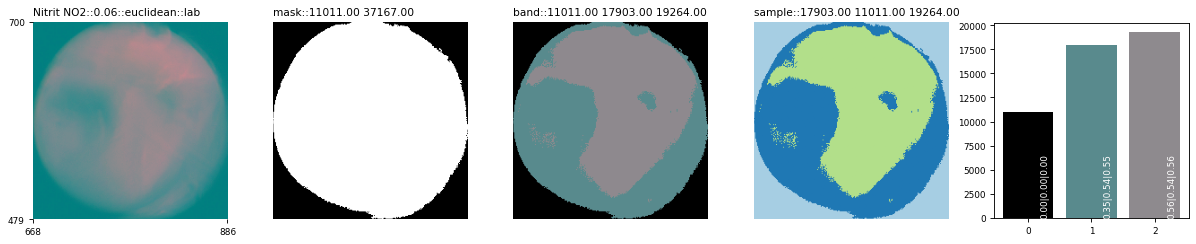

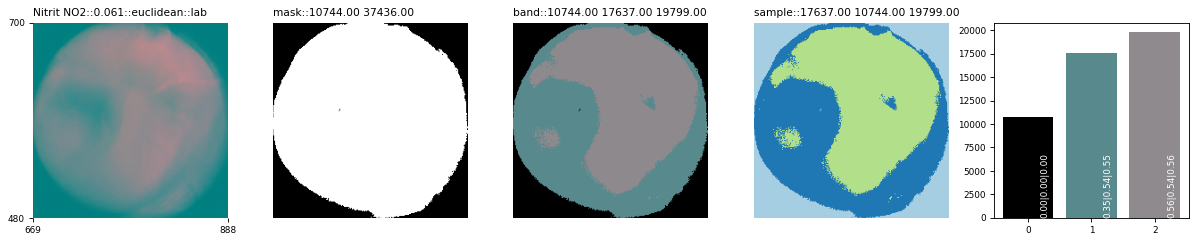

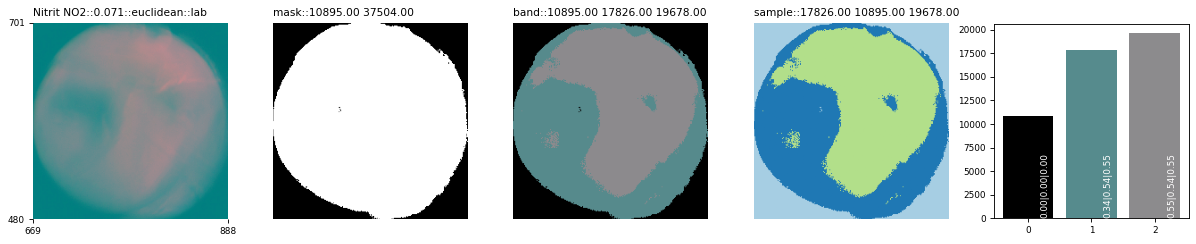

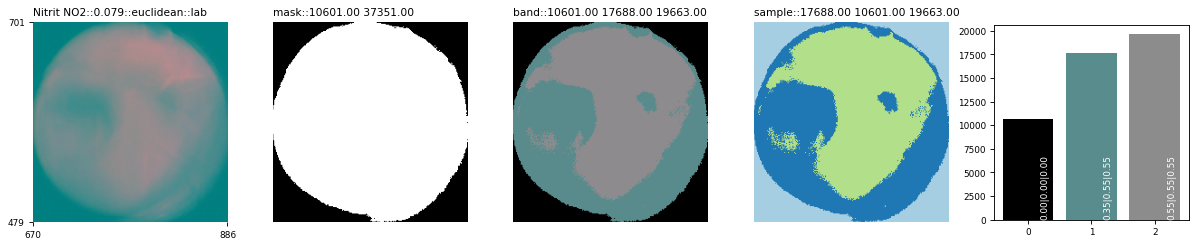

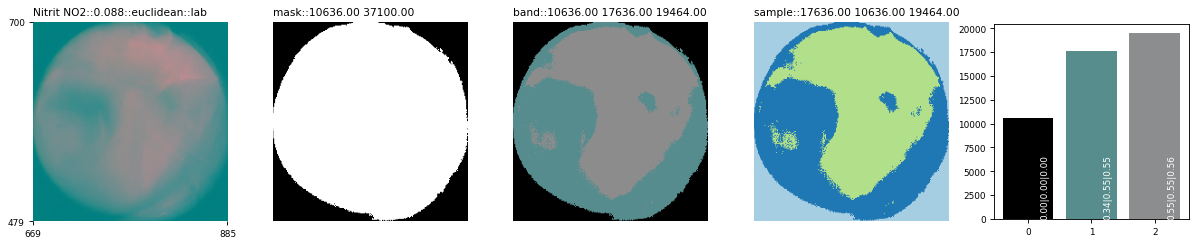

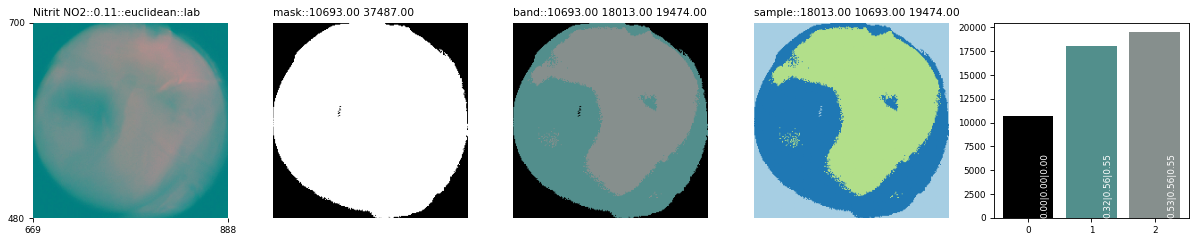

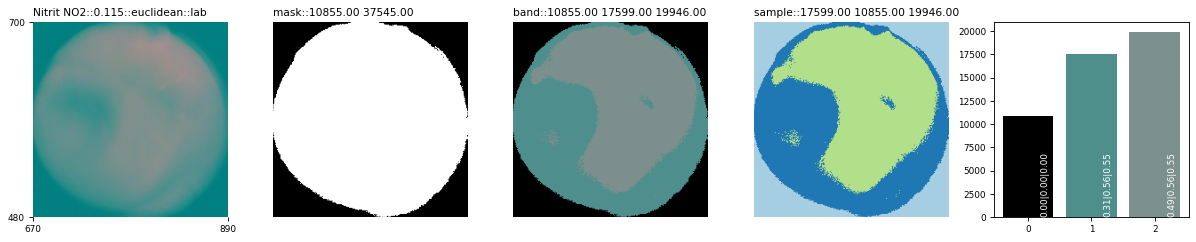

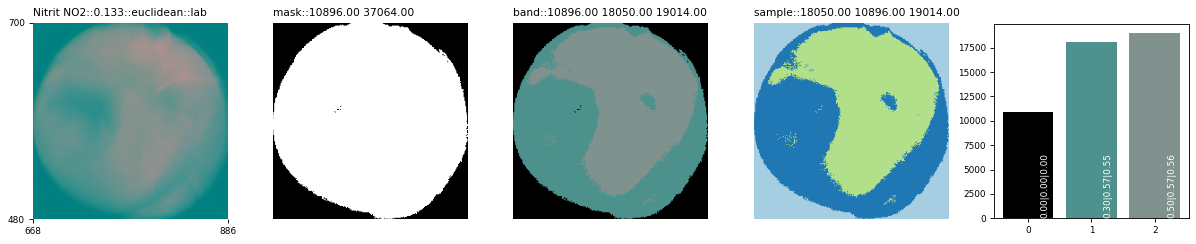

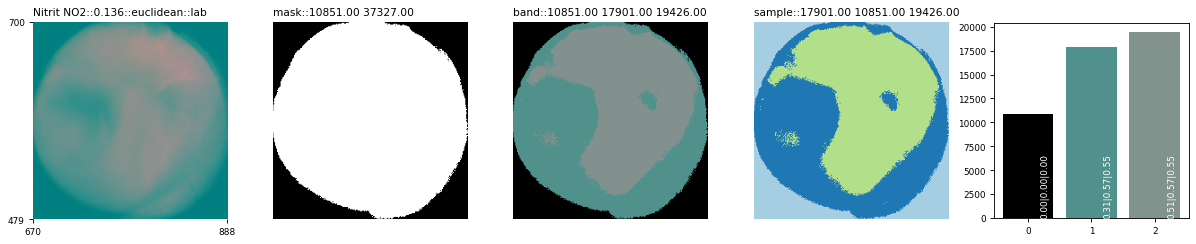

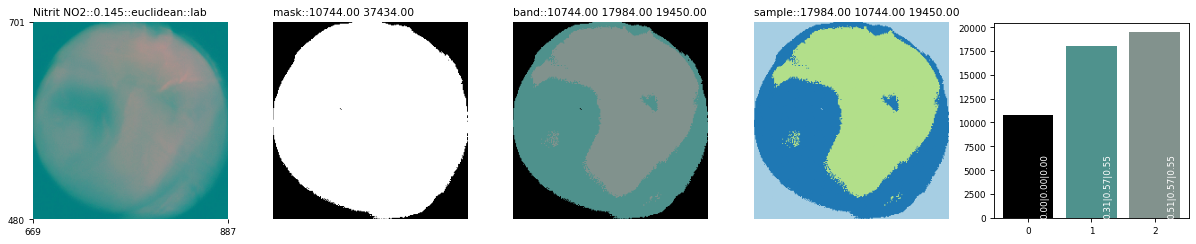

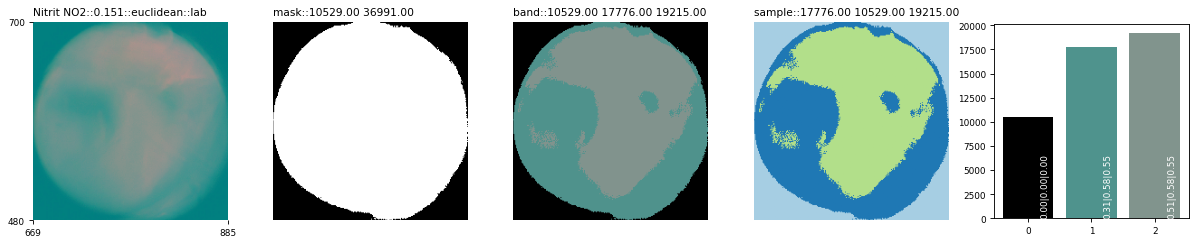

In [4]:
partitions = []

for item in items[:]:

    fname = item["fname"]
    name = os.path.split(os.path.normpath(fname))[1]
    label = os.path.basename(os.path.split(os.path.normpath(fname))[0])

    image = item["image"]    
    centers = item["centers"]
    labels = item["labels"]

    shape = image.shape

    # clustered image view
    sample = centers[labels].reshape(shape[0],shape[1],3).astype(np.float32)
    # mask the relevant information area
    band,mask,zoom = ZMeansUtils.mask_(sample,centers,labels,mode="min")
    # color mapping to make results comparable
    sample = ZMeansUtils.colormap_(sample,centers,labels,plt.cm.Paired)
    # zoom to mask area
    images = ZMeansUtils.zoom_([image,mask[:,:,np.newaxis]*255.,band,sample],zoom)
    # extract partitions
    partition = ZMeansUtils.partition_(images[1:])

    # ---------------------------

    titles = [
        "image","mask","band","sample"
    ]

    # ---------------------------

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80

    w = 3
    h = w*shape[1]/shape[0]

    nrows,ncols = 1,len(images)+1
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[w*ncols,h*nrows],
                        dpi=plt.rcParams["figure.dpi"])

    for i,a in enumerate(np.array(ax.ravel())[:-1]):
        if i==0:
            a.set_xlim(zoom[2:4]-zoom[2]); a.set_xticks(zoom[2:4]-zoom[2]); a.set_xticklabels(zoom[2:4])
            a.set_ylim(zoom[:2]-zoom[0]); a.set_yticks(zoom[:2]-zoom[0]); a.set_yticklabels(zoom[:2])
        else:
            a.set_xlim(zoom[2:4]-zoom[2]); a.set_xticks([])
            a.set_ylim(zoom[:2]-zoom[0]); a.set_yticks([])
        for loc in ["top","right","bottom","left"]: a.spines[loc].set_visible(False)

    for i,image in enumerate(images):

        ax[i].imshow(image,cmap=plt.cm.Greys_r,origin="lower")

        title = "%s"%(titles[i])
        if i==0:
            title = "%s::%s::%s::%s"%(fproject,label,metric,space)
        else:
            title = "%s::%s"%(title," ".join(["%.2f"%(p) for p in partition[i-1][-1]]))
        ax[i].set_title(title,x=0,ha="left")

    ll,pp = partition[-2]
    xx = np.arange(len(pp))
    w = 0.8
    ax[-1].bar(x=xx,height=pp,color=ll,width=w)
    ax[-1].set_aspect((ax[-1].get_xlim()[1]-ax[-1].get_xlim()[0])/(ax[-1].get_ylim()[1]-ax[-1].get_ylim()[0]))
    ax[-1].set_xticks(xx)    
    for i,l in enumerate(ll):
        ann = "|".join(["%.2f"%(v) for v in l])
        col = "white"
        ax[-1].annotate("%s"%ann,xy=(i+w/3,0.025),rotation=90,ha="center",va="bottom",color=col,fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(fpath,"result","%s.%s.%s.png"%(space,metric,label)))    
    plt.show()
    plt.close()

    partitions.append(partition[-2])

### single point of view 
  
plot (single point value of) partitions for every concentration for every channel  
  
- relevant partitions are non-black
- 3 clusters a reduced to 2  
  
for the NO2 sample it is shown, that the channels **L** and **a** of the **Lab** color space are modified by concentration changes  

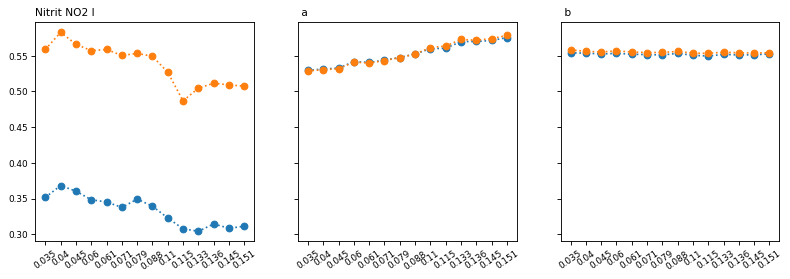

In [5]:

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

w = 4
h = 4

nrows,ncols = 1,3
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[w*ncols,h*nrows],
                    dpi=plt.rcParams["figure.dpi"],sharey=True)

for k,j in enumerate([-2,-1]):
  pp = np.array([partition[0][j] for partition in partitions])
  pp = pp.flatten().reshape(-1,3)    
  for i in range(pp.shape[1]): 
    yy = pp[:,i]
    ax[i].plot(yy,"o:")
    ax[i].set_xticks(np.arange(len(yy)))
    ax[i].set_xticklabels(flabels,rotation=35)

for i in range(len(space)):
  ax[i].set_title("%s %s"%(fproject if i==0 else "",space[i]),x=0,ha="left")
  asp = (ax[i].get_xlim()[1]-ax[i].get_xlim()[0])/(ax[i].get_ylim()[1]-ax[i].get_ylim()[0])
  ax[i].set_aspect(asp)

#plt.tight_layout()
plt.savefig(os.path.join(fpath,"result","%s.%s.dimension.png"%(space,metric))) 
plt.show()
plt.close()

### store 
  
store (indexed) items in a pickle to compare and merge later to ther project data  
  
every row gives project name, index (0 and 1 for light-dark), label, metric, space, space vector

In [10]:
import pandas as pd

columns = ["project","index","label","metric","space"] + list(space)
fc = pd.DataFrame(columns=columns)

for k,j in enumerate([-2,-1]):

  N = len(flabels)
  cc = np.column_stack([np.array([fproject]*N).T,np.array([k]*N).T,np.array(flabels).T,np.array([metric]*N).T,np.array([space]*N).T])

  pp = np.array([partition[0][j] for partition in partitions])
  pp = pp.flatten().reshape(-1,3)  
  
  for i in range(pp.shape[1]): 
    yy = pp[:,i]

    cc = np.column_stack([cc,yy])
  
  fc = pd.concat([fc,pd.DataFrame(cc,columns=columns)])

for c in ["label"]+list(space): fc[c] = fc[c].astype(np.float32)
for c in ["index"]: fc[c] = fc[c].astype(np.int8)

fc = fc.reset_index(drop=True)
fname = os.path.join(fpath,"result","%s.%s.values.pickle"%(space,metric))
pd.to_pickle(fc,fname)

print("store", os.path.basename(fname), "\n")

print(fc.to_markdown())


store lab.euclidean.values.pickle 

|    | project    |   index |   label | metric    | space   |        l |        a |        b |
|---:|:-----------|--------:|--------:|:----------|:--------|---------:|---------:|---------:|
|  0 | Nitrit NO2 |       0 |   0.035 | euclidean | lab     | 0.351554 | 0.529403 | 0.554066 |
|  1 | Nitrit NO2 |       0 |   0.04  | euclidean | lab     | 0.368202 | 0.53157  | 0.553719 |
|  2 | Nitrit NO2 |       0 |   0.045 | euclidean | lab     | 0.360287 | 0.53266  | 0.55242  |
|  3 | Nitrit NO2 |       0 |   0.06  | euclidean | lab     | 0.348242 | 0.5418   | 0.553428 |
|  4 | Nitrit NO2 |       0 |   0.061 | euclidean | lab     | 0.345196 | 0.540679 | 0.552162 |
|  5 | Nitrit NO2 |       0 |   0.071 | euclidean | lab     | 0.337483 | 0.543833 | 0.551637 |
|  6 | Nitrit NO2 |       0 |   0.079 | euclidean | lab     | 0.349165 | 0.547556 | 0.551148 |
|  7 | Nitrit NO2 |       0 |   0.088 | euclidean | lab     | 0.339264 | 0.552494 | 0.553381 |
|  8 | Nitrit 

last (manual) update: 2023-08-28